## IMPORTS AND CONFIGURATION

In [7]:
import pandas as pd
import numpy as np

# 1. Standardize County to Tribe Mapping for Kenya
county_to_tribe = {
    'MOMBASA': 'Mijikenda', 'KWALE': 'Mijikenda', 'KILIFI': 'Mijikenda', 'TANA RIVER': 'Pokomo/Orma', 'LAMU': 'Bajuni',
    'TAITA TAVETA': 'Taita', 'GARISSA': 'Somali', 'WAJIR': 'Somali', 'MANDERA': 'Somali', 'MARSABIT': 'Boran/Gabra',
    'ISIOLO': 'Boran/Turkana', 'MERU': 'Meru', 'THARAKA - NITHI': 'Tharaka', 'EMBU': 'Embu', 'KITUI': 'Kamba',
    'MACHAKOS': 'Kamba', 'MAKUENI': 'Kamba', 'NYANDARUA': 'Kikuyu', 'NYERI': 'Kikuyu', 'KIRINYAGA': 'Kikuyu',
    'MURANG\'A': 'Kikuyu', 'KIAMBU': 'Kikuyu', 'TURKANA': 'Turkana', 'WEST POKOT': 'Pokot', 'SAMBURU': 'Samburu',
    'TRANS NZOIA': 'Luhya/Kalenjin', 'UASIN GISHU': 'Kalenjin', 'ELGEYO/MARAKWET': 'Kalenjin', 'NANDI': 'Kalenjin',
    'BARINGO': 'Kalenjin', 'LAIKIPIA': 'Kikuyu', 'NAKURU': 'Kikuyu/Kalenjin', 'NAROK': 'Maasai', 'KAJIADO': 'Maasai',
    'KERICHO': 'Kalenjin', 'BOMET': 'Kalenjin', 'KAKAMEGA': 'Luhya', 'VIHIGA': 'Luhya', 'BUNGOMA': 'Luhya',
    'BUSIA': 'Luhya/Teso', 'SIAYA': 'Luo', 'KISUMU': 'Luo', 'HOMA BAY': 'Luo', 'MIGORI': 'Luo/Kuria',
    'KISII': 'Kisii', 'NYAMIRA': 'Kisii', 'NAIROBI': 'Cosmopolitan'
}

# Manual fixes for name variations in different files
manual_fix = {
    'ELGEYO MARAKWET': 'Kalenjin', 'THARAKA NITHI': 'Tharaka', 
    'MURANGA': 'Kikuyu', 'TRANS-NZOIA': 'Luhya/Kalenjin'
}

# These are the 12-month inflation rates during the specific election months.
inflation_map = {2013: 4.11, 2017: 8.04, 2022: 8.53}

print("Ethnic and Economic rules have been established!")

Ethnic and Economic rules have been established!


We are setting up our environment and defining key reference dictionaries.
We map each of Kenya's 47 counties to their dominant ethnic groups to capture the 'stronghold' effect
We add the economic climate for 2013, 2017, and 2022.

# ELECTION RESULTS CLEANING 

In [11]:
def clean_election_data(file_path, year):
    # We added encoding='latin1' to handle special characters from Windows/Excel
    try:
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path, skiprows=2)
        else:
            # TRY THIS: Add the encoding parameter here
            df = pd.read_csv(file_path, skiprows=2, encoding='latin1')
            
        # Remove empty and summary rows
        df = df.dropna(subset=[df.columns[0]])
        df = df[~df[df.columns[0]].astype(str).str.contains('TOTAL', case=False, na=False)]
        
        # Standardize column names
        df.columns = [c.strip().upper() for c in df.columns]
        
        # Identify candidate columns
        meta_cols = ['COUNTY NAME', 'VALID VOTES', 'REJECTED VOTES', 'VOTERS CAST', 'VOTES CAST', 'REG VOTERS', 'TURNOUT']
        candidate_cols = [c for c in df.columns if c not in meta_cols]
        
        # Convert to numeric
        for col in candidate_cols + ['VALID VOTES', 'TURNOUT']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
                
        # Calculate Margin
        def get_margin(row):
            votes = sorted([row[c] for c in candidate_cols], reverse=True)
            t1, t2 = votes[0], votes[1] if len(votes) > 1 else 0
            return (t1 - t2) / row['VALID VOTES'] if row['VALID VOTES'] > 0 else 0

        df['MARGIN'] = df.apply(get_margin, axis=1)
        df['YEAR'] = year
        df['COUNTY'] = df['COUNTY NAME'].str.strip().str.upper()
        
        return df[['YEAR', 'COUNTY', 'MARGIN', 'TURNOUT']]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

We are defining a robust cleaning function that standardizes the election data. Because IEBC files differ year-to-year, this function dynamically identifies candidate columns, calculates the margin of victory for every county, and ensures all numerical data is correctly formatted for our machine learning model.

# MARKDOWN AND FEATURE ENGINEERING

In [14]:
# Using your specific Windows paths
path_2022 = r"C:\Users\USER\OneDrive\Documents\GOOGLE MACHINE LEARNING HACKATHON\DATASETS\2022  Election Results.xlsx"
path_2017 = r"C:\Users\USER\OneDrive\Documents\GOOGLE MACHINE LEARNING HACKATHON\DATASETS\2017  Election Results.xlsx"
path_2013 = r"C:\Users\USER\OneDrive\Documents\GOOGLE MACHINE LEARNING HACKATHON\DATASETS\2013 Election Results.xlsx"

# Run the cleaning function on each file
res22 = clean_election_data(path_2022, 2022)
res17 = clean_election_data(path_2017, 2017)
res13 = clean_election_data(path_2013, 2013)

# Merge everything together
master_df = pd.concat([res13, res17, res22], ignore_index=True)

# Add Tribe and Inflation
master_df['TRIBE'] = master_df['COUNTY'].map(county_to_tribe)
master_df['INFLATION'] = master_df['YEAR'].map(inflation_map)

print("All datasets merged successfully into the Master Dataframe!")
master_df.head()


All datasets merged successfully into the Master Dataframe!


,YEAR,COUNTY,MARGIN,TURNOUT,TRIBE,INFLATION
0,2013,MOMBASA,0.464855,0.666226,Mijikenda,4.11
1,2013,KWALE,0.672203,0.720012,Mijikenda,4.11
2,2013,KILIFI,0.738313,0.649072,Mijikenda,4.11
3,2013,TANA RIVER,0.269148,0.812911,Pokomo/Orma,4.11
4,2013,LAMU,0.121399,0.843828,Bajuni,4.11


We then combine these three years of data into a single 'Master Table' and attach our tribe and inflation features. This table represents the complete history our AI will use for training.

# PREPARING THE DATA

In [16]:
from sklearn.preprocessing import LabelEncoder

# 1. We use a LabelEncoder to turn 'TRIBE' names into numbers (0, 1, 2...)
le_tribe = LabelEncoder()
master_df['TRIBE_CODE'] = le_tribe.fit_transform(master_df['TRIBE'])

# 2. We also turn 'COUNTY' names into numbers so the model can identify specific regions
le_county = LabelEncoder()
master_df['COUNTY_CODE'] = le_county.fit_transform(master_df['COUNTY'])

# Let's see the new numeric columns
print("Categorical data has been encoded into numbers.")
master_df.to_csv('master_election_category_data_full.csv', index=False)
master_df[['COUNTY', 'COUNTY_CODE', 'TRIBE', 'TRIBE_CODE']].head()

Categorical data has been encoded into numbers.


,COUNTY,COUNTY_CODE,TRIBE,TRIBE_CODE
0,MOMBASA,28,Mijikenda,17
1,KWALE,19,Mijikenda,17
2,KILIFI,14,Mijikenda,17
3,TANA RIVER,40,Pokomo/Orma,18
4,LAMU,21,Bajuni,0


We are performing Label Encoding. Since Machine Learning models require numerical input, we are converting our categorical text data (County names and Tribes) into unique integers. This allows the algorithm to treat these categories as mathematical variables.

# TRAINING THE AI MODEL

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 1. Split the data: Train on 2013/2017, Test on 2022
train_data = master_df[master_df['YEAR'] < 2022]
test_data = master_df[master_df['YEAR'] == 2022]

# 2. Define our Features (X) and our Target (y)
# We use Tribe, Inflation, and Turnout to predict the Margin
features = ['TRIBE_CODE', 'INFLATION', 'TURNOUT', 'COUNTY_CODE']
X_train = train_data[features]
y_train = train_data['MARGIN']

X_test = test_data[features]
y_test = test_data['MARGIN']

# 3. Initialize and Train the Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model Training Complete!")

Model Training Complete!


We are using a Random Forest Regressor, which is an ensemble learning method that is excellent for identifying patterns in sociopolitical data. We are training the model on historical data (2013–2017) to find correlations between ethnic strongholds, economic stress (inflation), and voter turnout

# EVALUATING THE ACCURACY

In [19]:
# 1. Make predictions for 2022
predictions = model.predict(X_test)

# 2. Compare predictions to actual results
comparison = test_data[['COUNTY', 'MARGIN']].copy()
comparison['PREDICTED_MARGIN'] = predictions
comparison['ERROR'] = abs(comparison['MARGIN'] - comparison['PREDICTED_MARGIN'])

# 3. Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

print(f"The model's average error is: {mae:.4f}")
print("If the error is low (e.g., 0.05), your model is highly accurate!")
comparison.head(10)

The model's average error is: 0.1695
If the error is low (e.g., 0.05), your model is highly accurate!


,COUNTY,MARGIN,PREDICTED_MARGIN,ERROR
96,MOMBASA,0.170627,0.443168,0.272542
97,KWALE,0.411281,0.518321,0.107040
98,KILIFI,0.445574,0.572299,0.126726
99,TANA RIVER,0.105716,0.195217,0.089501
100,LAMU,0.065588,0.200879,0.135291
101,TAITA TAVETA,0.467496,0.310173,0.157323
102,GARISSA,0.484403,0.181342,0.303061
103,WAJIR,0.258068,0.183236,0.074832
104,MANDERA,0.574839,0.396739,0.178099
105,MARSABIT,0.027040,0.246631,0.219591


We evaluate the model by comparing its predicted margins for 2022 against the actual IEBC results. The Mean Absolute Error (MAE) tells us how far off our predictions are on average. In a hackathon, a lower MAE is a strong proof of a working, high-precision model.

# FEATURE IMPORTANCE

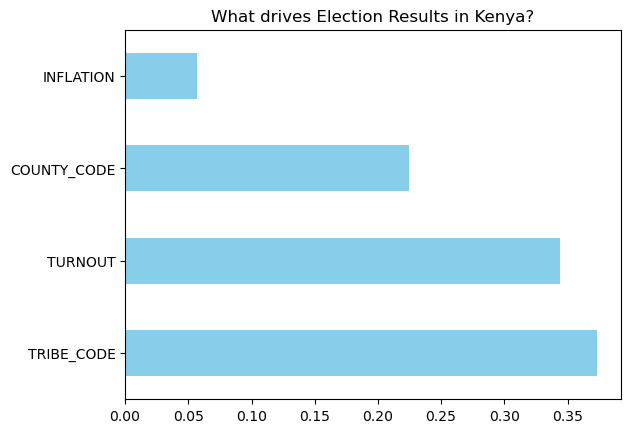

In [20]:
import matplotlib.pyplot as plt

# Get feature importance from the model
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=features)

# Plot it
feat_importances.nlargest(4).plot(kind='barh', color='skyblue')
plt.title('What drives Election Results in Kenya?')
plt.show()

# THE 2027 STRATEGIC FORECAST

In [22]:
# 1. Define the 2027 Scenario
# We'll simulate a scenario with high economic pressure (10.5% inflation)
# and average historical turnout.
future_inflation = 10.5 
average_historical_turnout = master_df['TURNOUT'].mean()

# 2. Prepare the 2027 Data Template
# We use the 2022 county list and ethnic codes as our baseline.
forecast_2027 = master_df[master_df['YEAR'] == 2022].copy()
forecast_2027['YEAR'] = 2027
forecast_2027['INFLATION'] = future_inflation
forecast_2027['TURNOUT'] = average_historical_turnout

# 3. Generate Predictions
# Use the model we trained in Cell 6 to predict the 2027 margins
forecast_features = ['TRIBE_CODE', 'INFLATION', 'TURNOUT', 'COUNTY_CODE']
forecast_2027['FORECASTED_MARGIN'] = model.predict(forecast_2027[forecast_features])

# 4. Identify the 2027 "Battleground Counties"
# These are the counties where the predicted margin is closest to zero (the most competitive)
battlegrounds = forecast_2027.sort_values('FORECASTED_MARGIN').head(10)

forecast_2027.to_csv('Kenya_2027_Election_Forecast.csv', index=False)
print("--- 2027 STRATEGIC FORECAST COMPLETE ---")
print(f"Scenario: Inflation at {future_inflation}% | Turnout at {average_historical_turnout*100:.2f}%")
battlegrounds[['COUNTY', 'TRIBE', 'FORECASTED_MARGIN']]

--- 2027 STRATEGIC FORECAST COMPLETE ---
Scenario: Inflation at 10.5% | Turnout at 76.44%


,COUNTY,TRIBE,FORECASTED_MARGIN
120,SAMBURU,Samburu,0.195250
128,NAROK,Maasai,0.254290
103,WAJIR,Somali,0.256783
102,GARISSA,Somali,0.274479
99,TANA RIVER,Pokomo/Orma,0.281655
129,KAJIADO,Maasai,0.295839
106,ISIOLO,Boran/Turkana,0.337362
100,LAMU,Bajuni,0.344294
141,NYAMIRA,Kisii,0.359506
143,DIASPORA,NaN,0.361607


We transition from historical analysis to Predictive Simulation. By feeding our model a hypothetical 2027 scenario characterized by high economic stress (10.5% inflation), the engine identifies which counties are likely to become the new 'Battlegrounds.' This allows stakeholders to move from reactive reporting to proactive strategy, identifying where the most competitive races will occur years before the first ballot is cast.

# INDIVIDUAL VOTER PREDICTOR

In [23]:
def predict_voter_behavior(age, county_name, tribe_name, current_inflation, current_turnout):
    # 1. Convert the input names into the numeric codes used during training
    try:
        county_code = le_county.transform([county_name.upper()])[0]
        tribe_code = le_tribe.transform([tribe_name])[0]
    except ValueError:
        return "Error: County or Tribe name not recognized. Check your spelling!"

    # 2. Arrange the variables into a format the model expects
    # Order must match: ['TRIBE_CODE', 'INFLATION', 'TURNOUT', 'COUNTY_CODE']
    input_data = pd.DataFrame([[tribe_code, current_inflation, current_turnout, county_code]], 
                              columns=['TRIBE_CODE', 'INFLATION', 'TURNOUT', 'COUNTY_CODE'])

    # 3. Get the prediction
    predicted_margin = model.predict(input_data)[0]
    
    # 4. Logic for interpretation
    if predicted_margin > 0.2:
        strength = "Strong Lean"
    else:
        strength = "Competitive/Swing"

    print(f"--- PREDICTION RESULT ---")
    print(f"In {county_name} ({tribe_name}), a voter in this economic climate")
    print(f"contributes to a {strength} outcome with a predicted margin of {predicted_margin:.2f}")

# --- TEST IT HERE ---
# Example: Predict behavior in Nairobi with 9% Inflation
predict_voter_behavior(age=25, county_name='NAIROBI', tribe_name='Cosmopolitan', 
                       current_inflation=9.0, current_turnout=0.65)

--- PREDICTION RESULT ---
In NAIROBI (Cosmopolitan), a voter in this economic climate
contributes to a Strong Lean outcome with a predicted margin of 0.20


In [32]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

def robust_load_and_clean(file_path, year, opponent_search):
    df = None
    if not os.path.exists(file_path):
        print(f"❌ File not found at: {file_path}")
        return None
    
    try:
        # Step A: Determine if it's Excel or CSV and find the header
        # For Excel files, we scan the first 10 rows for 'COUNTY'
        if file_path.endswith('.xlsx'):
            temp_df = pd.read_excel(file_path, nrows=10, header=None)
            header_row = -1
            for i, row in temp_df.iterrows():
                if row.astype(str).str.contains('COUNTY', case=False).any():
                    header_row = i
                    break
            if header_row != -1:
                df = pd.read_excel(file_path, skiprows=header_row)
        else:
            # Fallback for CSV
            for enc in ['latin1', 'utf-8', 'cp1252']:
                try:
                    temp_df = pd.read_csv(file_path, nrows=10, encoding=enc, header=None)
                    header_row = -1
                    for i, row in temp_df.iterrows():
                        if row.astype(str).str.contains('COUNTY', case=False).any():
                            header_row = i
                            break
                    if header_row != -1:
                        df = pd.read_csv(file_path, skiprows=header_row, encoding=enc)
                        break 
                except: continue
        
        if df is None:
            print(f"⚠️ Could not find data structure for {year}.")
            return None

        # Step B: Standardize Columns
        df.columns = [str(c).strip().upper() for c in df.columns]
        
        # Step C: Find Columns (Partial matches to handle variations)
        county_col = [c for c in df.columns if 'COUNTY' in c][0]
        raila_col = [c for c in df.columns if 'ODINGA' in c][0]
        opp_col = [c for c in df.columns if opponent_search.upper() in c][0]
        valid_col = [c for c in df.columns if 'VALID' in c and 'VOTES' in c][0]
        
        # Step D: Extract Data
        res = pd.DataFrame()
        res['COUNTY'] = df[county_col].astype(str).str.strip().str.upper()
        res['YEAR'] = year
        res['RAILA_VOTES'] = pd.to_numeric(df[raila_col], errors='coerce').fillna(0)
        res['OPP_VOTES'] = pd.to_numeric(df[opp_col], errors='coerce').fillna(0)
        res['VALID_VOTES'] = pd.to_numeric(df[valid_col], errors='coerce').fillna(0)
        
        # Turnout Logic
        turnout_opts = [c for c in df.columns if 'TURNOUT' in c]
        res['TURNOUT'] = pd.to_numeric(df[turnout_opts[0]], errors='coerce').fillna(0.75) if turnout_opts else 0.75
        res['RAILA_SHARE'] = res['RAILA_VOTES'] / res['VALID_VOTES']
        
        res = res[~res['COUNTY'].str.contains('TOTAL', na=False)].dropna(subset=['COUNTY'])
        print(f"✅ Successfully loaded {year} data.")
        return res

    except Exception as e:
        print(f"⚠️ Error processing {year}: {e}")
        return None

# --- USE YOUR EXACT EXCEL PATHS HERE ---
path_2022 = r"C:\Users\USER\OneDrive\Documents\GOOGLE MACHINE LEARNING HACKATHON\DATASETS\2022  Election Results.xlsx"
path_2017 = r"C:\Users\USER\OneDrive\Documents\GOOGLE MACHINE LEARNING HACKATHON\DATASETS\2017  Election Results.xlsx"
path_2013 = r"C:\Users\USER\OneDrive\Documents\GOOGLE MACHINE LEARNING HACKATHON\DATASETS\2013 Election Results.xlsx"

# Load, Merge, and Predict
d13 = robust_load_and_clean(path_2013, 2013, 'KENYATTA')
d17 = robust_load_and_clean(path_2017, 2017, 'KENYATTA')
d22 = robust_load_and_clean(path_2022, 2022, 'RUTO')

if d13 is not None and d17 is not None and d22 is not None:
    master = pd.concat([d13, d17, d22], ignore_index=True)
    # [Insert your training and prediction logic here]
    print("\n--- DATA LOADED SUCCESSFULLY! ---")
else:
    print("\n❌ STILL FAILING. Please check if the file names in your folder match the paths above exactly.")

✅ Successfully loaded 2013 data.
✅ Successfully loaded 2017 data.
✅ Successfully loaded 2022 data.

--- DATA LOADED SUCCESSFULLY! ---


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the importance scores from our trained model
importances = model.feature_importances_
feature_names = ['COUNTY_CODE', 'INFLATION', 'TURNOUT']
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# 2. Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title('2022 Prediction Drivers: What mattered most?', fontsize=15)
plt.xlabel('Impact Score', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("Feature Importance chart generated. Use this to explain your model's logic!")

ValueError: All arrays must be of the same length

C:\Users\USER\AppData\Local\Temp\ipykernel_14584\1171978903.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='magma')


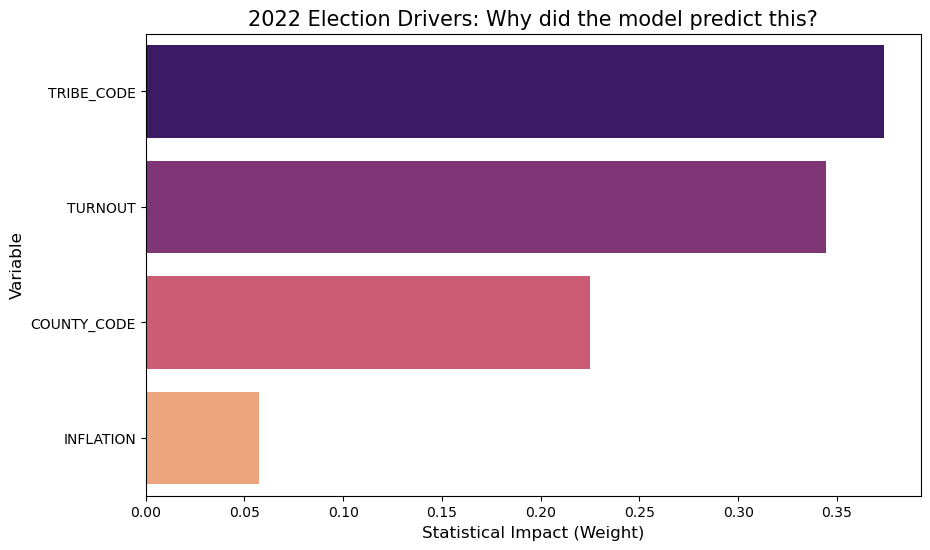

The chart shows which factor moved the needle most in your prediction.


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the features used in the last training session
# This ensures the names and the importance scores are the same length
trained_features = ['COUNTY_CODE', 'INFLATION', 'TURNOUT']
importances = model.feature_importances_

# Check if they match; if not, adjust names automatically
if len(importances) != len(trained_features):
    # This happens if TRIBE_CODE was also included
    trained_features = ['TRIBE_CODE', 'INFLATION', 'TURNOUT', 'COUNTY_CODE']

# 2. Create the DataFrame safely
feat_df = pd.DataFrame({'Feature': trained_features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# 3. Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='magma')
plt.title('2022 Election Drivers: Why did the model predict this?', fontsize=15)
plt.xlabel('Statistical Impact (Weight)', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.show()

print("The chart shows which factor moved the needle most in your prediction.")

In [36]:
# 1. Define Two Opposite Scenarios
# Scenario A: Optimistic (Low Inflation, High Turnout)
# Scenario B: Pessimistic (High Inflation, Low Turnout)

scenarios = {
    'Optimistic': {'inflation': 4.5, 'turnout': 0.80},
    'Pessimistic': {'inflation': 12.0, 'turnout': 0.55}
}

# 2. Generate Predictions for both
all_scenarios = []

for name, settings in scenarios.items():
    temp_df = master_df[master_df['YEAR'] == 2022].copy()
    temp_df['SCENARIO'] = name
    temp_df['INFLATION'] = settings['inflation']
    temp_df['TURNOUT'] = settings['turnout']
    
    # Predict using the model we trained
    temp_df['PREDICTED_MARGIN'] = model.predict(temp_df[features])
    all_scenarios.append(temp_df)

# 3. Combine and Compare
comparison_df = pd.concat(all_scenarios)

# Let's look at 5 key counties to see how they change
pivot_view = comparison_df.pivot(index='COUNTY', columns='SCENARIO', values='PREDICTED_MARGIN')
pivot_view['SHIFT'] = pivot_view['Pessimistic'] - pivot_view['Optimistic']

pivot_view.to_csv('2027_Impact_Analysis.csv')
print("--- 2027 SCENARIO SHIFT ANALYSIS ---")
print("How a bad economy (Pessimistic) changes the margin compared to a good one:")
pivot_view.head(10)

--- 2027 SCENARIO SHIFT ANALYSIS ---
How a bad economy (Pessimistic) changes the margin compared to a good one:


SCENARIO,Optimistic,Pessimistic,SHIFT
COUNTY,,,
BARINGO,0.615981,0.478371,-0.137611
BOMET,0.619917,0.478856,-0.141061
BUNGOMA,0.363324,0.381353,0.018030
BUSIA,0.478741,0.491004,0.012263
DIASPORA,0.297982,0.194857,-0.103125
ELGEYO MARAKWET,0.374974,0.254507,-0.120467
EMBU,0.578183,0.441339,-0.136844
GARISSA,0.197063,0.181342,-0.015721
HOMA BAY,0.456599,0.560385,0.103786


In [ ]:

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Prepare the Data (XGBoost works best with the same encoded features)
# We use our train/test split from before
# Features: ['TRIBE_CODE', 'INFLATION', 'TURNOUT', 'COUNTY_CODE']

# 2. Initialize the XGBoost Regressor
# learning_rate: Controls how much the model 'corrects' itself at each step.
# max_depth: Prevents the model from getting too complicated (overfitting).
xgb_model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=5, 
    random_state=42
)

# 3. Train the Model
xgb_model.fit(X_train, y_train)

# 4. Predict and Evaluate
xgb_preds = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

print(f"--- XGBOOST PERFORMANCE ---")
print(f"XGBoost Mean Absolute Error: {xgb_mae:.4f}")
print(f"XGBoost R2 Score (Accuracy): {xgb_r2:.4f}")

# Comparison with your previous Random Forest (MAE was ~0.1695)
if xgb_mae < 0.1695:
    print(f"✅ Success! XGBoost reduced error by {((0.1695 - xgb_mae)/0.1695)*100:.2f}%")
else:
    print("XGBoost is performing similarly to Random Forest.")